

# AMLS Assignment Draft
## Task B: CNN on BloodMNIST Dataset

Explore CNN based classifiers on the BloodMNIST dataset.

## Import libraries
The required libraries for this notebook are sklearn, copy, numpy and matplotlib.

In [19]:
## first enable autoreload during development so latest (new) version local code library is reloaded on execution 
## can be commented out when local code development not happening to avoid overhead
%load_ext autoreload
%autoreload 2

## import libraries
import io
import numpy as np
import matplotlib.pyplot as plt

## tqdm callback moved to AMLS_common
        
## import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, Hinge

## local code library
import AMLS_common as ac

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set base parameters
Including hyperparameters and environment specifics

In [20]:
## Initialize hyperparameters
parameter = ac.HyperParameters(learning_rate=0.001, 
                               batch_size=128, 
                               num_epochs=50, 
                               num_filter=16,
                               layers=3,
                               dropout_rate=0.2,
                               optimise="Adam",
                               loss="SparseCategoricalCrossentropy()")

tqdm_callback = ac.TqdmEpochProgress(total_epochs=parameter.num_epochs)

In [21]:
## control (e.g. verbose) parameters
filebase   = "metrics/"          ## place to save output files
verbose    = 1                   ## to control whether additional in process information is printed

## Load and preprocess the BloodMNIST Data
We load the dataset.

In [22]:
## Loading the data file using common MedMINST loader
data_flag  = 'bloodmnist'        # defines which dataset to load
result_set = ac.medMNIST_load(data_flag,parameter.batch_size)

## check that the loader returned data correctly and then split out
if result_set != []:
    train_dataset = result_set[0]
    test_dataset  = result_set[1]
    val_dataset   = result_set[2]

if verbose == 1:
    ## print summary stats for training dataset
    print("\nSummary metrics for train_dataset")
    print("type:",type(train_dataset))
    print("length:",len(train_dataset))
    print("shape:",train_dataset)

Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz

Summary metrics for train_dataset
type: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
length: 94
shape: <BatchDataset shapes: ((None, 28, 28, 3), (None, 1)), types: (tf.float64, tf.float32)>


## Define the CNN model

Define a base model

In [23]:
## Define the model
if verbose == 1:
    print("Default activation is ",parameter.default_activation)
    
model = Sequential([
    Conv2D(64, (3, 3), activation=parameter.default_activation, input_shape=(28, 28, 3)),   ## Input layer
    Conv2D(16, (3, 3), activation=parameter.default_activation),                            ## Convolution layer 
    MaxPooling2D((2, 2)),                                                                   ## Reduce the features
    Conv2D(16, (3, 3), activation=parameter.default_activation),                            ## Another Convolution layer 
    MaxPooling2D((2, 2)),                                                                   ## Again reduce the features
    Flatten(),                                                                              # Flatten
    Dropout(0.2),                                                                           # added dropout
    Dense(8, activation='softmax')                                                          # Output layer for 8 types 
])

print(model.summary())
## Redirect the summary output to a string
summary_string = io.StringIO()
model.summary(print_fn=lambda x: summary_string.write(x + "\n"))
summary_content = summary_string.getvalue()
summary_string.close()

optimizer_choice = str(parameter.optimise)+'(learning_rate='+str(parameter.learning_rate)+')'
optimizer        = eval(optimizer_choice)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                                                   
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics='acc')

Default activation is  relu
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 16)        9232      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dropout_2 (Dropout)       

## Fit the model

Fit using hyperparameters as defined above

50 128


Epoch Progress: 100%|██████████| 50/50 [37:44<00:00, 45.28s/epoch, loss=0.321, acc=0.886, val_loss=0.326, val_acc=0.891] 


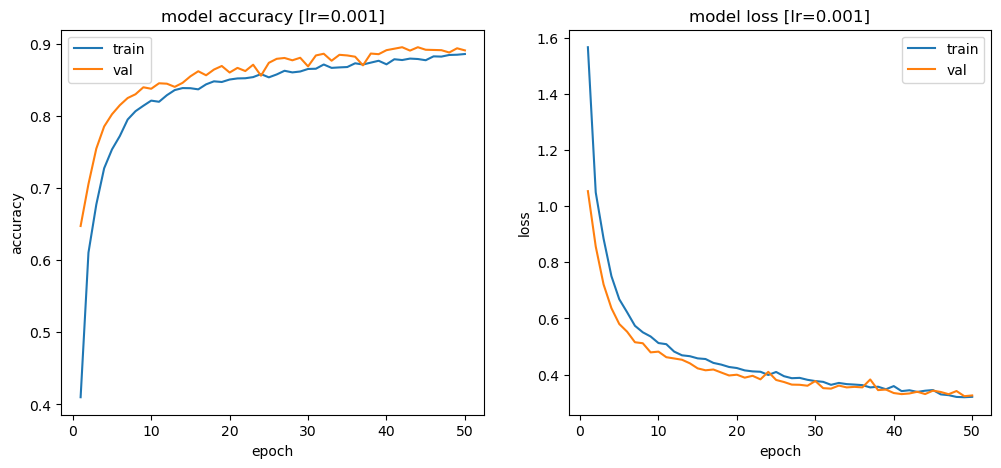

Files saved: metrics/metrics_2024_12_23_at_090604.xlsx metrics/summary_2024_12_23_at_090604.txt


['metrics/metrics_2024_12_23_at_090604.xlsx',
 'metrics/summary_2024_12_23_at_090604.txt',
 RunResult(min_loss=0.3194781541824341, max_acc=0.8859436511993408, last_loss=0.320877343416214, last_acc=0.8859436511993408, var_loss=0.045671823330981326, var_acc=0.006560151743570833),
 HyperParameters(learning_rate=0.001, batch_size=128, num_epochs=50, optimise='Adam', loss='SparseCategoricalCrossentropy()', num_filter=16, strides=16, padding='valid', dropout_rate=0.2, layers=3, default_activation='relu')]

In [24]:
## Fit the model
if verbose == 1:
    print(parameter.num_epochs,parameter.batch_size)
    
history = model.fit(train_dataset, 
                    validation_data=test_dataset, 
                    epochs=parameter.num_epochs, 
                    batch_size=parameter.batch_size, 
                    verbose=0,
                    callbacks = [tqdm_callback])

## output graphs and save metrics files
ac.graph_and_save(history,summary_content,parameter,filebase)